# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [3]:
def evalSWE(ax, ds, obs, labels=None, iterVar=None, palette='Set1'):
    # Tsurf scatter plot    
    with sns.color_palette(palette):
        if iterVar is None:
            iterVar = ds.expID
        for n, e in enumerate(iterVar):
            if not labels is None:
                l = labels[n]
            else:
                l = None
            ax.plot(ds.sel(expID=e).time, ds.sel(expID=e).scalarSWE, label=l, linewidth=2)

        ax.set_ylabel('SWE (mm)')
        if not labels is None:
            ax.legend(loc='upper left')
    return(ax)

def sortFun(s):
    if 'high' in s and 'L' in s:
        return(4)
    elif 'high' in s and 'S' in s:
        return(3)
    elif 'low' in s and 'S' in s:
        return(2)
    elif 'low' in s and 'L' in s:
        return(1)

## Forcing data

In [4]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.forcing.nc')
SWA = xr.concat([SWA, xr.open_dataset('SWA.summaResults.internal.nc')], 'expID')
print(SWA)

CDP = xr.open_dataset('CDP.summaResults.forcing.nc')
CDP = xr.concat([CDP, xr.open_dataset('CDP.summaResults.internal.nc')], 'expID')
print(CDP)

<xarray.Dataset>
Dimensions:                (expID: 45, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) object 'longwaveBias' 'longwaveBias' ...
    family                 (expID) object 'lowLW' 'lowLW' 'highLW' 'highLW' ...
  * expID                  (expID) object 'lowLW_L' 'lowLW_S' 'highLW_S' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.784e-07 3.584e-09 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.338e-12 7.387e-14 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.1 280.9 279.7 278.8 ...
    scalarSenHeatTotal     (expID, time) float64 -75.53 -20.79 -19.85 -15.34 ...
    scalarLatHeatTotal     (expID, time) float64

## Model output

In [5]:
# ----------
# Experiment names - Structure Uncertainty
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias', 'layers',
               'thermalCond', 'stability']
expMetUnc = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']
expIntern = ['layers', 'thermalCond', 'stability']
experimentType = {'forcing': expMetUnc, 'internal': expIntern}
force = {'SWA': SWAforce, 'CDP': CDPforce}
results = {'SWA': SWA, 'CDP': CDP}

# Met uncertainty experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}

metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

metNameTitle = {'longwaveBias': 'Longwave Bias (Wm$^{-2}$)',
           'shortwaveBias': 'Shortwave Bias (Wm$^{-2}$)',
           'specHumidBias': 'Relative Humiditiy Bias (%)',
           'airTempBias': 'Air Temperature Bias ($^{\circ}$C)',
           'windBias': 'Wind Speed Bias (m s$^{-1}$)'}

# Layer
expNames['layers'] = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']

# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

internalNames = {'stability': ['standard', 'louisinv', 'mahrtexp'],
                 'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010'],
                 'thermalCond': ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']}

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [6]:
print(CDP.swap_dims({'expID': 'exp'}).sel(exp='longwaveBias'))

<xarray.Dataset>
Dimensions:                (exp: 4, time: 70127)
Coordinates:
  * time                   (time) datetime64[ns] 2002-10-01 ...
  * exp                    (exp) object 'longwaveBias' 'longwaveBias' ...
    family                 (exp) object 'lowLW' 'lowLW' 'highLW' 'highLW'
    expID                  (exp) object 'lowLW_L' 'lowLW_S' 'highLW_S' ...
Data variables:
    scalarRainPlusMelt     (exp, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (exp, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (exp, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (exp, time) float64 1.999e-07 1.29e-08 4.303e-09 ...
    scalarSurfaceRunoff    (exp, time) float64 3.74e-12 2.768e-13 9.088e-14 ...
    scalarSurfaceTemp      (exp, time) float64 286.0 285.0 284.3 283.8 283.4 ...
    scalarSenHeatTotal     (exp, time) float64 -64.66 -34.8 -27.22 -23.53 ...
    scalarLatHeatTotal     (exp, time) float64 -72.53 -38.63 -29.25 

In [7]:
def water_year(time_index, last_month=9):
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year')


In [8]:
os.chdir(dirPrint)
for s in siteNames:
    for exp in expMetUnc:
        ds = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        ds = ds.swap_dims({'exp': 'expID'})
        ds = ds.groupby(water_year(ds.time))

        for nYear, (wYear, wYearSWE) in enumerate(ds):
            with sns.color_palette('RdBu_r', 4):
                fig, ax = plt.subplots(1, 1, figsize= (6, 6))
                iterVar = sorted(expNames[exp], key=sortFun)
                ax = evalSWE(ax, wYearSWE, force[s], iterVar=iterVar,
                             labels=iterVar)
                fig.autofmt_xdate()
                fig.savefig(s + '.' + exp + '.SWE.WY' + str(wYear) + '.pdf', bbox_inches='tight')
                fig.clf();

//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [9]:
os.chdir(dirPrint)
for s in siteNames:
    for exp in expIntern:
        ds = results[s].swap_dims({'expID': 'exp'}).sel(exp=exp)
        ds = ds.swap_dims({'exp': 'expID'})
        ds = ds.groupby(water_year(ds.time))

        for nYear, (wYear, wYearSWE) in enumerate(ds):
            with sns.color_palette('Set1'):
                fig, ax = plt.subplots(1, 1, figsize= (6, 6))
                ax = evalSWE(ax, wYearSWE, force[s])
                fig.autofmt_xdate()
                fig.savefig(s + '.' + exp + '.SWE.WY' + str(wYear) + '.pdf', bbox_inches='tight')
                fig.clf();

//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


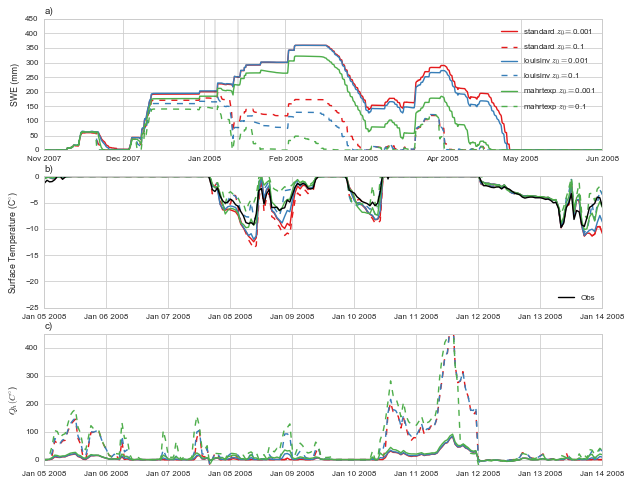

In [95]:
fig, axes = plt.subplots(3, 1, figsize= (10, 8), sharex=False)
ax = axes[0]
ds = results['CDP']
ds = ds.swap_dims({'expID': 'exp'}).sel(exp='stability').swap_dims({'exp': 'expID'})
color = sns.color_palette('Set1')
c = {'standard': color[0], 'louisinv': color[1], 'mahrtexp': color[2]}
title = {'standard': 'Anderson', 'louisinv': 'Louis', 'mahrtexp': 'Marht'}

# SWE
for e in ds.expID:
    if 'Mid' in str(ds.sel(expID=e).expID.values):
        continue
    elif 'Low' in str(ds.sel(expID=e).expID.values):
        label = str(ds.sel(expID=e).family.values) + ' $z_0=$' + str(0.001)
        ls = '-'
    elif 'High' in str(ds.sel(expID=e).expID.values):
        label = str(ds.sel(expID=e).family.values) + ' $z_0=$' + str(0.1)
        ls = '--'
    ax.plot(ds.time, ds.sel(expID=e).scalarSWE.values, label=label, ls=ls, color=c[str(ds.sel(expID=e).family.values)])
ax.legend()
ax.plot([datetime(2008, 1, 5), datetime(2008, 1, 5)], [0, 450], 'k', linewidth=0.2)
ax.plot([datetime(2008, 1, 14), datetime(2008, 1, 14)], [0, 450], 'k', linewidth=0.2)
ax.set_xlim(datetime(2007, 11, 1), datetime(2008, 6, 1))
ax.set_ylabel('SWE (mm)')
ax.set_title('a)', loc='left')

# Tsurf
ax = axes[1]
for e in ds.expID:
    if 'Mid' in str(ds.sel(expID=e).expID.values):
        continue
    elif 'Low' in str(ds.sel(expID=e).expID.values):
        ls = '-'
    elif 'High' in str(ds.sel(expID=e).expID.values):
        ls = '--'
    ax.plot(ds.time, ds.sel(expID=e).scalarSurfaceTemp.values - 273.15,
            ls=ls, color=c[str(ds.sel(expID=e).family.values)])
ax.plot(CDPforce.time, CDPforce.Tsrf, color='k', label='Obs')
ax.legend(loc='lower right')
ax.set_xlim(datetime(2008, 1, 5), datetime(2008, 1, 14))
ax.set_ylabel('Surface Temperature (C$^{\circ}$)')
ax.set_ylim(-25, 0)
ax.set_title('b)', loc='left')

# Qh
ax = axes[2]
for e in ds.expID:
    if 'Mid' in str(ds.sel(expID=e).expID.values):
        continue
    elif 'Low' in str(ds.sel(expID=e).expID.values):
        ls = '-'
    elif 'High' in str(ds.sel(expID=e).expID.values):
        ls = '--'
    ax.plot(ds.time, ds.sel(expID=e).scalarSenHeatTotal.values,
            ls=ls, color=c[str(ds.sel(expID=e).family.values)])
ax.legend(loc='lower right')
ax.set_xlim(datetime(2008, 1, 5), datetime(2008, 1, 14))
ax.set_ylim(-20, 450)
ax.set_ylabel('$Q_h (C^{\circ}$)')
ax.set_title('c)', loc='left')

os.chdir(dirPrint)
fig.savefig('CDP.Tsfc_SWE.TimeSeries.WY2008.pdf')

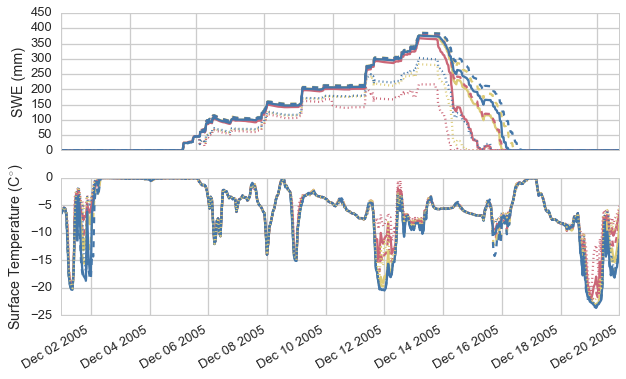

In [27]:
fig, axes = plt.subplots(2, 1, figsize= (10, 6))
ax = axes[0]
evalSWE(ax, stab, CDP, stabLabel, stabLineStyle, stabColor)
ax.legend_.remove()
fig.autofmt_xdate()

ax = axes[1]
for s in stab:
    ax.plot(stab[s].time, stab[s].scalarSurfaceTemp - 273.15, color=stabColor[s], linestyle=stabLineStyle[s])
ax.set_xlim(datetime(2005, 12, 1), datetime(2005, 12, 20))
ax.set_ylim(-25, 0)
ax.set_ylabel('Surface Temperature (C$^{\circ}$)')
fig.autofmt_xdate()

os.chdir(dirPrint)
fig.savefig('ModTsfc.WSC17.Tsfc_SWE.TimeSeries.pdf')

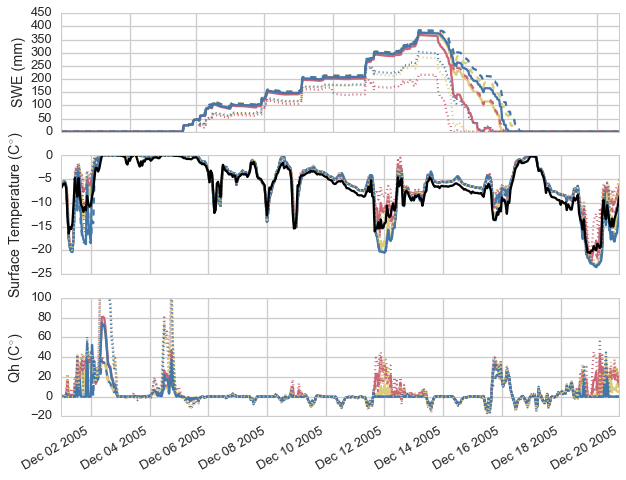

In [32]:
fig, axes = plt.subplots(3, 1, figsize= (10, 8))
ax = axes[0]
evalSWE(ax, stab, CDP, stabLabel, stabLineStyle, stabColor)
ax.legend_.remove()
fig.autofmt_xdate()

ax = axes[1]
for s in stab:
    ax.plot(stab[s].time, stab[s].scalarSurfaceTemp - 273.15, color=stabColor[s], linestyle=stabLineStyle[s])
ax.plot(CDP.time, CDP.Tsrf, color='k', label='Obs')
ax.set_xlim(datetime(2005, 12, 1), datetime(2005, 12, 20))
ax.set_ylim(-25, 0)
ax.set_ylabel('Surface Temperature (C$^{\circ}$)')
fig.autofmt_xdate()

ax = axes[2]
for s in stab:
    ax.plot(stab[s].time, stab[s].scalarSenHeatTotal, color=stabColor[s], linestyle=stabLineStyle[s])
ax.set_xlim(datetime(2005, 12, 1), datetime(2005, 12, 20))
ax.set_ylim(-20, 100)
ax.set_ylabel('Qh (C$^{\circ}$)')
fig.autofmt_xdate()

os.chdir(dirPrint)
fig.savefig('SWA.Tsfc_SWE.TimeSeries.pdf')

In [ ]:
fig, axes = plt.subplots(3, 1, figsize= (10, 8))
ax = axes[0]
evalSWE(ax, stab, CDP, stabLabel, stabLineStyle, stabColor)
ax.legend_.remove()
fig.autofmt_xdate()

ax = axes[1]
for s in stab:
    ax.plot(stab[s].time, stab[s].scalarSurfaceTemp - 273.15, color=stabColor[s], linestyle=stabLineStyle[s])
ax.plot(CDP.time, CDP.Tsrf, color='k', label='Obs')
ax.set_xlim(datetime(2005, 12, 1), datetime(2005, 12, 20))
ax.set_ylim(-25, 0)
ax.set_ylabel('Surface Temperature (C$^{\circ}$)')
fig.autofmt_xdate()

ax = axes[2]
for s in stab:
    ax.plot(stab[s].time, stab[s].scalarSenHeatTotal, color=stabColor[s], linestyle=stabLineStyle[s])
ax.set_xlim(datetime(2005, 12, 1), datetime(2005, 12, 20))
ax.set_ylim(-20, 100)
ax.set_ylabel('Qh (C$^{\circ}$)')
fig.autofmt_xdate()

os.chdir(dirPrint)
fig.savefig('SWA.Tsfc_SWE.TimeSeries.pdf')